In [53]:
# compare the data/mc for cluster shape/position, variables used for BDT training

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
a=tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [54]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


ver = 'V1p17'
sig_ver = 'v160'
singleMuon = True
for year in ['16', '17', '18']:
    data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data20'+year+'/v5/'+sig_ver+'/normalized/'
    if year == '16':fpath_bkg['data16'] = data_path + "Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"
    elif year == '17':fpath_bkg['data17'] = data_path + "Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"
    else:fpath_bkg['data18'] = data_path +"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"




In [55]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print(a.shape)

data16 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2016/v5/v160/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root
(286219,)
data17 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v160/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
(344706,)
data18 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v160/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root
(487341,)


# Cluster-level variables with cluster requirement

In [56]:
%%time

sel_tp = {}
pileupWeight = {}
weight = {}
clusterSize = {}
clusterEta = {}
clusterTimeSpread = {}
clusterTimeTotal = {}
clusterMe11Ratio = {}
clusterMB1Ratio = {}
clusterMatchMB1 = {}
clusterMatchRPC = {}
clusterMaxStation = {}
clusterTimeSpreadWeightedAll = {}
clusterTimeWeighted = {}
sel_lep = {}
sel_ev = {}
cut_based = {}
probe_index = {}
sel_tp = {}
cond = {}
mc_corr_weight = {}
clusterNSegmentStation1 = {}
clusterNSegmentStation2 = {}
clusterNSegmentStation3 = {}
clusterNSegmentStation4 = {}
clusterNStation = {}
clusterStationRatio = {}
ZMass = {}
lepEta = {}
rho = {}
muonEta_weight = {}
npv = {}
muonPt = 50
tag_probe = True
norm = False
text = False
scaling = 'norm'
m1, m2 = '120', '800' 
region = 'dt'
for k, T in tree_bkg.items():
# for k in ['data_'+m1+'_'+m2, 'dy_'+m1+'_800']:
    sel_cluster = np.abs(T.array(region+ 'RechitClusterSize'))>=0
    sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array(region+ 'RechitClusterZLep1') == 1, T.array(region+ 'RechitClusterZLep2') == 1))

    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array(region+'RechitClusterMuonVetoPt')) > muonPt)
    
    if tag_probe: 
        sel_cluster1 =np.logical_and(sel_cluster,  T.array(region+ 'RechitClusterZLep1') == 1)   #loose lepton
        sel_cluster2 = np.logical_and(sel_cluster,  T.array(region+ 'RechitClusterZLep2') == 1)  

# ########### BRANCHES ############
    sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
    sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
    sel_ev[k] = sel_lep[k].sum()>=1
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)


    if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
    if m1 == '50':
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=60)
    else:
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(m1))

    sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<int(m2))
    probe_index[k] = []
    sel_tp[k] = []
    cond[k] = []
    sel_probecluster = []
    pdgid = T.array("lepPdgId")


    index = 0
    for i, ev in enumerate(sel_ev[k]):
        if ev:
            if sel_lep[k][i][0]:
                probe_index[k].append([False,True])
                sel_tp[k].append(index)
                if pdgid[i][0] == 13:
#                     cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))

                    cond[k].append(sel_cluster2[i].sum()==1)

                    if cond[k][-1]: sel_probecluster.append(sel_cluster2[i])
                else:
#                     cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 

                    cond[k].append(sel_cluster1[i].sum()==1)

                    if cond[k][-1]:sel_probecluster.append(sel_cluster1[i])
            if sel_lep[k][i][1]:
                probe_index[k].append([True, False])
                sel_tp[k].append(index)
                if pdgid[i][0] == -13:
#                     cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    cond[k].append(sel_cluster2[i].sum()==1)
                    if cond[k][-1]:sel_probecluster.append(sel_cluster2[i])
                else:
#                     cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                    cond[k].append(sel_cluster1[i].sum()==1)


                    if cond[k][-1]:sel_probecluster.append(sel_cluster1[i])
            index+=1
    sel_tp[k] = np.array(sel_tp[k])
    probe_index[k] = np.array(probe_index[k])

    cond[k] = np.array(cond[k])
    sel_probecluster = awkward.fromiter(sel_probecluster)
    print("here")
    print(len(sel_probecluster))
    clusterEta[k] = awkward.fromiter(T.array(region+ 'RechitClusterEta')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    clusterSize[k] = awkward.fromiter(T.array(region+ 'RechitClusterSize')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    print("here")
    if region == 'csc':
        clusterTimeSpread[k] = awkward.fromiter(T.array('cscRechitClusterTimeSpread')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeTotal[k] = awkward.fromiter(T.array('cscRechitClusterTimeTotal')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeSpreadWeightedAll[k] = awkward.fromiter(T.array('cscRechitClusterTimeSpreadWeightedAll')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeWeighted[k] = awkward.fromiter(T.array('cscRechitClusterTimeWeighted')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMe11Ratio[k] = awkward.fromiter(T.array('cscRechitClusterMe11Ratio')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    else:
        clusterMB1Ratio[k] = awkward.fromiter((T.array('dtRechitClusterNSegmentStation1')/T.array('dtRechitClusterSize'))[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMatchRPC[k] = awkward.fromiter(T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMatchMB1[k] = awkward.fromiter(T.array('dtRechitCluster_match_MB1hits_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMaxStation[k] = awkward.fromiter(T.array('dtRechitClusterMaxStation')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        
        clusterNSegmentStation1[k] = awkward.fromiter(T.array('dtRechitClusterNSegmentStation1')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterNSegmentStation2[k] = awkward.fromiter(T.array('dtRechitClusterNSegmentStation2')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterNSegmentStation3[k] = awkward.fromiter(T.array('dtRechitClusterNSegmentStation3')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterNSegmentStation4[k] = awkward.fromiter(T.array('dtRechitClusterNSegmentStation4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

    
        cut = 5
        clusterNStation[k] = ((T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int))[sel_ev[k]][sel_tp[k]][cond[k]][sel_probecluster][:,0]

        max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
        min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
        clusterStationRatio[k] = (min_station/max_station)[sel_ev[k]][sel_tp[k]][cond[k]][sel_probecluster][:,0]


        

    print(k)
    lepEta[k] = np.stack(np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]]))[probe_index[k]]

    npv[k] = T.array('npv')[sel_ev[k]][sel_tp[k]]
    rho[k] = T.array('rho')[sel_ev[k]][sel_tp[k]]

here
41690
here
data16
here
53321
here
data17
here
85730
here
data18
CPU times: user 2min 56s, sys: 2.61 s, total: 2min 59s
Wall time: 3min 4s


# CSC Cluster plots

/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_norm_V1p17v160_tag_probe/
4 4 4 4
data16 clusterTimeWeighted efficiency 0.9950693937180424 0.0009414638224388705 0.0011397403785650129
<nullptr TFitResult>
data17 clusterTimeWeighted efficiency 0.9891276210199327 0.0011787830695011436 0.0013123511199882865
<nullptr TFitResult>
data18 clusterTimeWeighted efficiency 0.9878257732888448 0.0010411521437467819 0.0011329472041441413
<nullptr TFitResult>
1.0000000000000002 0.9999999999999999 1.0000000000000002
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_norm_V1p17v160_tag_probe/csc_clusterTimeWeighted_withRatio_muonPt50_120_800_norm
 FCN=64.4657 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=6.4848e-08    STRATEGY= 1      ERROR MATRI

Warning in <TROOT::Append>: Replacing existing TH1: data16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data18 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data18 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_norm_V1p17v160_tag_probe/csc_clusterTimeWeighted_withRatio_muonPt50_120_800_norm.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/Muon

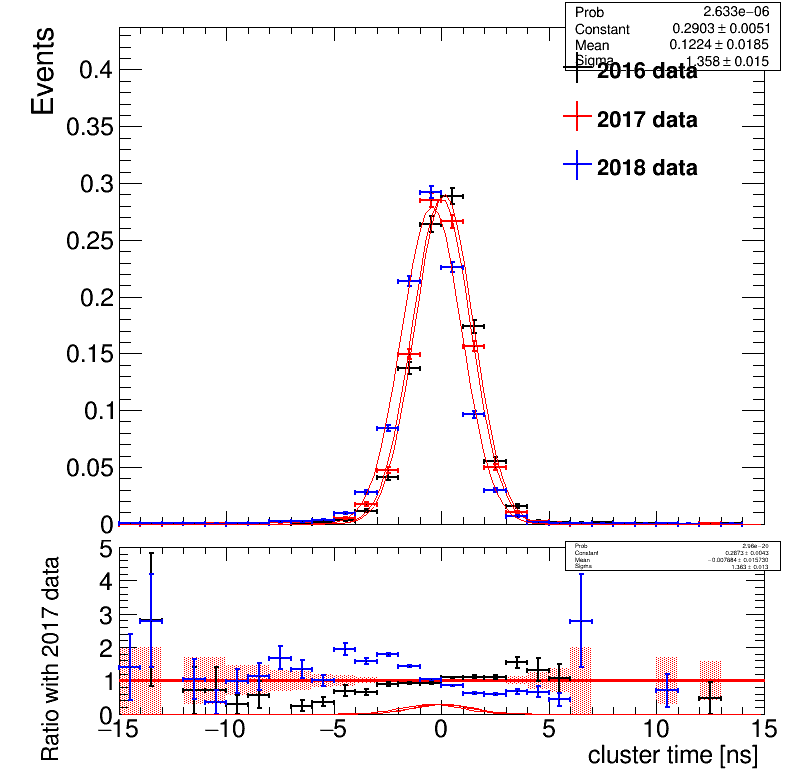

In [30]:

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_'+scaling+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)
if region == 'dt': Nrechits_cut = 80
else: Nrechits_cut = 100
        
var = [clusterSize, clusterTimeWeighted, clusterTimeSpreadWeightedAll,clusterMe11Ratio]
names = ['clusterSize', 'clusterTimeWeighted', 'clusterTimeSpreadWeightedAll','clusterMe11Ratio']
title = ['N_{rechits}',  'cluster time [ns]','cluster strip time spread [ns]', 'ME11 ratio']
bins = [ [0, 30, 40,50, 60,80, 100, 150, 250, 500], [30,-15,15],  list(np.arange(0,20,2))+list(np.arange(20,35,5))+[50],[20,0,1.1]]

ratio_list = [[0.5,1.5], [0,5], [0,3], [0,3]]



print(len(var) , len(title) , len(names) , len(bins))
assert(len(var) == len(title) == len(names) == len(bins))
norm = 1
fit = 1
npv_weighted = 0
key_plot = ['data_'+m1+'_'+m2, 'dy_'+m1+'_'+m2]
for j,v in enumerate(var):
#     if region == 'csc' and j >= 4:continue
#     if region == 'dt' and j > 0 and j <= 3:continue
    if not j == 1:continue
    h = {}
    sel = {}
    new_cond = {}
    maximum = 0
    for i,k in enumerate(tree_bkg.keys()):

        selections = [
        clusterSize[k]>=Nrechits_cut,
        np.logical_and(clusterTimeWeighted[k]<12.5, clusterTimeWeighted[k]>-5),
        clusterTimeSpreadWeightedAll[k]<20,
        clusterMe11Ratio[k]<1,

        ]
        sel[k] = clusterSize[k]>=0
        for l, s in enumerate(selections):
            if l == j:continue
            sel[k] = np.logical_and(sel[k], s)
        new_cond[k] = selections[j][sel[k]]
        
    for i,k in enumerate(tree_bkg.keys()):
        if npv_weighted and not '17' in k:
            reweight_var = npv
            h_reweight = {}
#             h_reweight['reweight'] = create_TH1D( reweight_var[k][sel[k]], axis_title=['', ''], name=k, binning=[20,0,200])
#             h_reweight['17'] = create_TH1D( reweight_var['data17'][sel['data17']], axis_title=['', ''], name='17', binning=[20,0,200])
            h_reweight['reweight'] = create_TH1D( reweight_var[k], axis_title=['', ''], name=k, binning=[25,0,100])
            h_reweight['17'] = create_TH1D( reweight_var['data17'], axis_title=['', ''], name='17', binning=[25,0,100])
            h_reweight['17'].Scale(1./h_reweight['17'].Integral())
            h_reweight['reweight'].Scale(1./h_reweight['reweight'].Integral())
            h_reweight['17'].Divide(h_reweight['reweight'])
            weight = []
            
            for m in range(len(reweight_var[k][cond[k]])):
                weight.append(h_reweight['17'].GetBinContent(h_reweight['17'].GetXaxis().FindFixBin(reweight_var[k][cond[k]][m])))
#             for m in range(len(reweight_var[k][cond[k]])):
#                 weight.append(h_reweight['17'].GetBinContent(h_reweight['17'].GetXaxis().FindFixBin(reweight_var[k][cond[k]][m])))
            weight = np.array(weight)
            
            
            
        else:weight = np.ones((len(reweight_var[k][cond[k]]),))
        
        if j >= 6:
            v[k][cond[k]][sel[k]]
            weight[sel[k]]
            print(len(weight), len(sel[k]))
            h[k] = create_TH1D( v[k][cond[k]][sel[k]], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = weight[sel[k]])
        else: h[k] = create_TH1D( v[k][sel[k]], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = weight[sel[k]])
#         for binx in range(h[k].GetNbinsX()):print(h[k].GetBinContent(binx+1))


        if norm: h[k].Scale(1./h[k].Integral())
        h[k].SetLineColor(std_color_list[i])
        
        if j == 0:
            if region == 'csc':
                eta_cut = np.logical_and(np.abs(lepEta[k])>0.9, np.abs(lepEta[k])<2.4)
                hm = create_TH1D( np.ones((np.count_nonzero(new_cond[k]),)), name=k, binning=[1,0,2], weights = weight[sel[k]][new_cond[k]])
                hb = create_TH1D( np.ones((np.count_nonzero(eta_cut)),), name=k, binning=[1,0,2])
                eff = rt.TEfficiency(hm,hb)
                print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
                
                for cut in Nrechits_cut-np.arange(10):
                    temp = np.logical_and(new_cond[k], clusterSize[k][sel[k]]>=cut)
                    hm = create_TH1D( np.ones((np.count_nonzero(temp),)), name=k, binning=[1,0,2])
                    eff = rt.TEfficiency(hm,hb)
                    print(k, cut, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))#             new_cond = 
            
            else:                 
                hm = create_TH1D( np.ones(np.count_nonzero(clusterSize[k][sel[k]]>=80)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2])
                hb = create_TH1D( np.ones(np.count_nonzero(clusterSize[k][sel[k]]>=50)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2])
                eff = rt.TEfficiency(hm,hb)
                print(k, eff.GetEfficiency(1), eff.GetEfficiencyErrorUp(1), eff.GetEfficiencyErrorLow(1))
            
            
        elif j == 6:continue
        else:
            hm = create_TH1D( np.ones((np.count_nonzero(new_cond[k]),)), name=k, binning=[1,0,2], weights = weight[sel[k]][new_cond[k]])
            hb = create_TH1D( np.ones((len(v[k][sel[k]]),)), name=k, binning=[1,0,2], weights = weight[sel[k]])
            eff = rt.TEfficiency(hm,hb)
            print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
            

            if j == 1 and fit:
                r = h[k].Fit('gaus')
                print(r)
    print(h['data16'].Integral(),h['data17'].Integral(),h['data18'].Integral())
    c = make_ratio_plot([h['data16'],h['data17'],h['data18']], fit = False, logy=False, in_tags = ['2016 data', '2017 data', '2018 data'], \
                        ratio_bounds = ratio_list[j], ratio_index = 1, draw_opt = ['E1','E2','E1']) 
        
    c.Draw()

    file_name = dir_name+region+'_'+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+m1+'_'+m2
    if norm: file_name += "_norm"
    if npv_weighted: file_name+="_npvweighted"
    print(file_name)

    c.SaveAs(file_name+".png")
    c.SaveAs(file_name+".C")



/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_norm_V1p17v160_tag_probe/
4 4 4 4
data16 0.13208007217223808 0.0016930742709365398 0.0016750020515371444
data17 0.13440665356809034 0.0015062787984907455 0.0014922418209159238
data18 0.1370447142434113 0.001193799747598534 0.0011851584885047284
0.9999999999999999 1.0 1.0
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_norm_V1p17v160_tag_probe/dt_clusterSize_withRatio_muonPt50_120_800_norm
data16 clusterMB1Ratio efficiency 0.9415956892056319 0.0031001231176510657 0.003257944824513581
data17 clusterMB1Ratio efficiency 0.9402188417400588 0.0027454481381801177 0.0028657889369128053
data18 clusterMB1Ratio efficiency 0.9467310367400377 0.0020351640116518244 0.0021097427111760325
1.0 1.0 0.9999999999999999
/storage/af/user/chri

Warning in <TROOT::Append>: Replacing existing TH1: data16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data18 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data18 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_norm_V1p17v160_tag_probe/dt_clusterSize_withRatio_muonPt50_120_800_norm.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_An

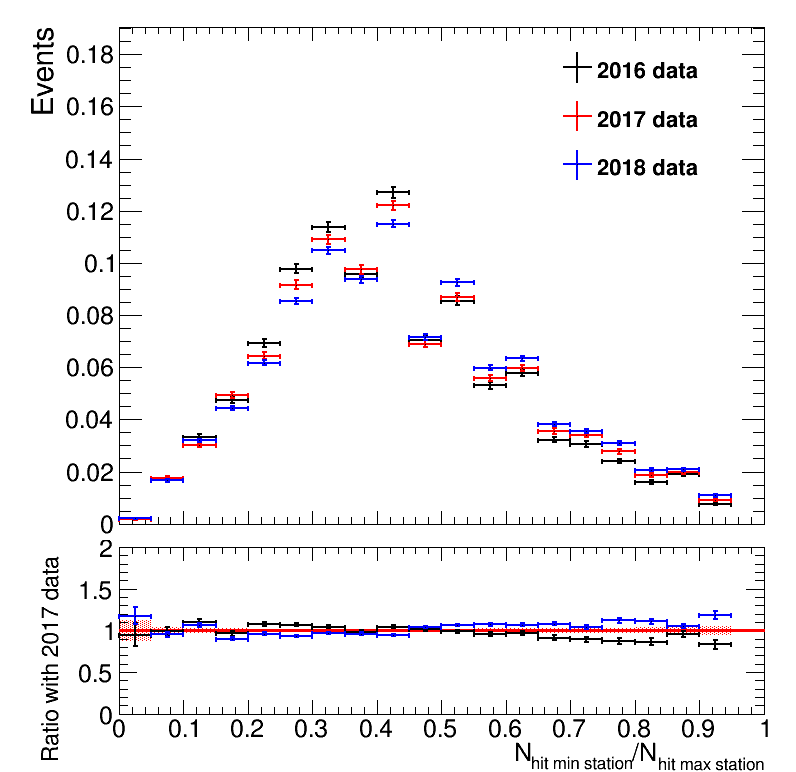

In [58]:
#DT plots

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_'+scaling+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)
if region == 'dt': Nrechits_cut = 80
else: Nrechits_cut = 100

var = [clusterSize, clusterMB1Ratio, clusterNStation, clusterStationRatio]
names = ['clusterSize', 'clusterMB1Ratio', 'clusterNStation', 'clusterStationRatio']
title = ['N_{rechits}', 'MB1 ratio', 'N_{station}', 'N_{hit min station}/N_{hit max station}']


bins = [ [0, 30, 50, 60,80, 100, 150, 250, 500], [21,0,1.05],  [5,0,5], [20,0,1]]

ratio_list = [[0.5,1.5], [0.0,2.0], [0,2], [0,2]]



print(len(var) , len(title) , len(names) , len(bins))
assert(len(var) == len(title) == len(names) == len(bins))
norm = 1
fit = 0
npv_weighted = 0
for j,v in enumerate(var):
#     if not j == 3:continue
#     if j <= 1:continue
    h = {}
    sel = {}
    new_cond = {}
    maximum = 0
    for i,k in enumerate(tree_bkg.keys()):
        selections = [
            clusterSize[k]>=80,
            clusterMB1Ratio[k]<0.9,
            clusterNStation[k] < 4,
            clusterStationRatio[k]<=0.4,
        ]
        sel[k] = clusterSize[k]>=50
        if not j == 0 and not j == 3:sel[k] = np.logical_and(sel[k], clusterSize[k]>=80)
        if not j == 1:sel[k] = np.logical_and(sel[k], clusterMB1Ratio[k]<0.9)
        if j == 3: sel[k] = np.logical_and(sel[k], clusterNStation[k]==4)
        new_cond[k] = selections[j][sel[k]]
    for i,k in enumerate(tree_bkg.keys()):
        if npv_weighted and not '17' in k:
            reweight_var = npv
            h_reweight = {}
#             h_reweight['reweight'] = create_TH1D( reweight_var[k][sel[k]], axis_title=['', ''], name=k, binning=[20,0,200])
#             h_reweight['17'] = create_TH1D( reweight_var['data17'][sel['data17']], axis_title=['', ''], name='17', binning=[20,0,200])
            h_reweight['reweight'] = create_TH1D( reweight_var[k], axis_title=['', ''], name=k, binning=[25,0,100])
            h_reweight['17'] = create_TH1D( reweight_var['data17'], axis_title=['', ''], name='17', binning=[25,0,100])
            h_reweight['17'].Scale(1./h_reweight['17'].Integral())
            h_reweight['reweight'].Scale(1./h_reweight['reweight'].Integral())
            h_reweight['17'].Divide(h_reweight['reweight'])
            weight = []
            
            for m in range(len(reweight_var[k][cond[k]])):
                weight.append(h_reweight['17'].GetBinContent(h_reweight['17'].GetXaxis().FindFixBin(reweight_var[k][cond[k]][m])))
#             for m in range(len(reweight_var[k][cond[k]])):
#                 weight.append(h_reweight['17'].GetBinContent(h_reweight['17'].GetXaxis().FindFixBin(reweight_var[k][cond[k]][m])))
            weight = np.array(weight)
            
            
            
        else:weight = np.ones((len(npv[k][cond[k]]),))
        
        if j >= 6:
            v[k][cond[k]][sel[k]]
            weight[sel[k]]
            print(len(weight), len(sel[k]))
            h[k] = create_TH1D( v[k][cond[k]][sel[k]], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = weight[sel[k]])
        else: h[k] = create_TH1D( v[k][sel[k]], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = weight[sel[k]])
#         for binx in range(h[k].GetNbinsX()):print(h[k].GetBinContent(binx+1))


        if norm: h[k].Scale(1./h[k].Integral())
        h[k].SetLineColor(std_color_list[i])
        
        if j == 0:
            
            hm = create_TH1D( np.ones(np.count_nonzero(clusterSize[k][sel[k]]>=80)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2])
            hb = create_TH1D( np.ones(np.count_nonzero(clusterSize[k][sel[k]]>=50)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2])
            eff = rt.TEfficiency(hm,hb)
            print(k, eff.GetEfficiency(1), eff.GetEfficiencyErrorUp(1), eff.GetEfficiencyErrorLow(1))

        
        else:
            hm = create_TH1D( np.ones((np.count_nonzero(new_cond[k]),)), name=k, binning=[1,0,2], weights = weight[sel[k]][new_cond[k]])
            hb = create_TH1D( np.ones((len(v[k][sel[k]]),)), name=k, binning=[1,0,2], weights = weight[sel[k]])
            eff = rt.TEfficiency(hm,hb)
            print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
            

            if j == 1 and fit:
                r = h[k].Fit('gaus')
                print(r)
    print(h['data16'].Integral(),h['data17'].Integral(),h['data18'].Integral())
    c = make_ratio_plot([h['data16'],h['data17'],h['data18']], fit = False, logy=False, in_tags = ['2016 data', '2017 data', '2018 data'], \
                        ratio_bounds = ratio_list[j], ratio_index = 1, draw_opt = ['E1','E2','E1']) 
        
    c.Draw()

    file_name = dir_name+region+'_'+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+m1+'_'+m2
    if norm: file_name += "_norm"
    if npv_weighted: file_name+="_npvweighted"
    print(file_name)

    c.SaveAs(file_name+".png")
    c.SaveAs(file_name+".C")



In [49]:
# calcualte efficiency of station < 4 OR ratio < 0.4
key_plot = ['data',  'dy_'+m1+'_'+m2]


for i,k in enumerate(tree_bkg.keys()):

    sel = clusterSize[k]>=50
    sel = np.logical_and(sel, clusterMB1Ratio[k]<0.9)

    new_cond = np.logical_or(clusterNStation[k]<4, clusterStationRatio[k]<0.4)[sel] #remove if both clusters are 4 stations

    hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2])
    hb = create_TH1D( np.ones((len(clusterSize[k][sel]),)), name=k, binning=[1,0,2])
    eff = rt.TEfficiency(hm,hb)
    print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))


data16 clusterStationRatio efficiency 0.629702777168215 0.002393401977770604 0.0023997591830476894
data17 clusterStationRatio efficiency 0.617381683612155 0.002130018819192725 0.0021345171403656105
data18 clusterStationRatio efficiency 0.5956055670713651 0.0016938414380311961 0.0016961142271799678


Warning in <TROOT::Append>: Replacing existing TH1: data16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data18 (Potential memory leak).


In [52]:
0.5956055670713651/0.617381683612155-1

-0.03527172431385217

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_yearCompare_muonShower_'+scaling+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)
if region == 'dt': Nrechits_cut = 80
else: Nrechits_cut = 100

var = [clusterSize, clusterTimeTotal, clusterTimeSpread,clusterMe11Ratio, clusterMB1Ratio, clusterMatchMB1, npv, rho]
names = ['clusterSize', 'clusterTimeTotal', 'clusterTimeSpread','clusterMe11Ratio', 'clusterMB1Ratio', 'clusterMatchMB1', 'npv','rho']
title = ['N_{rechits}',  'cluster time [ns]','cluster strip time spread [ns]', 'ME11 ratio', 'MB1 ratio', 'clusterMatchMB1', 'npv', 'rho']

bins = [ [50, 60,80, 100, 150, 250, 500], [30,-15,15],  list(np.arange(0,20,2))+list(np.arange(20,35,5))+[50],[21,0,1.05],[20,0,1], [50,0,50], [25,0,100], [25,0,100]]
ratio_list = [[0.5,1.5], [0,3], [0,2], [0,7], [0.5,2], [0,5],[0,5], [0,5]]

# ratio_list = [[0.5,5], [0,3], [0,2], [0,3], [0.5,2], [0,5],[0,5]]

#        [0, 10,20,30,40,50, 70, 100, 150, 250, 500], [0, 10,20,30,40,50, 70, 100, 150, 250, 500],\
#        [0, 10,20,30,40,50, 70, 100, 150, 250, 500],[0, 10,20,30,40,50, 70, 100, 150, 250, 500]]


print(len(var) , len(title) , len(names) , len(bins))
assert(len(var) == len(title) == len(names) == len(bins))
norm = 1
fit = 0
npv_weighted = 0
key_plot = ['data_'+m1+'_'+m2, 'dy_'+m1+'_'+m2]
for j,v in enumerate(var):
#     if region == 'csc' and j >= 4:continue
#     if region == 'dt' and j > 0 and j <= 3:continue
    if not j == 0:continue
    h = {}
    sel = {}
    new_cond = {}
    maximum = 0
    for i,k in enumerate(tree_bkg.keys()):
        if region == 'csc':
            selections = [
            clusterSize[k]>=0,
            np.logical_and(clusterTimeTotal[k]<12.5, clusterTimeTotal[k]>-5),
            clusterTimeSpread[k]<20,
            clusterMe11Ratio[k]<1.0,
            clusterSize[k]>=0,
            clusterSize[k]>=0,
            clusterSize[k]>=0,
            clusterSize[k]>=0,

            ]
        else:
            selections = [
            clusterSize[k]>=Nrechits_cut,
            clusterSize[k]>=0,
            clusterSize[k]>=0,
            clusterSize[k]>=0,
            clusterMB1Ratio[k]<0.9,
#             clusterMatchMB1[k]<=1,
           
#             clusterMB1Ratio[k]<0.9,
#             clusterMatchRPC[k] >= 0,
            ]
        sel[k] = clusterSize[k]>=0
        for l, s in enumerate(selections):
            if l == j:continue
            sel[k] = np.logical_and(sel[k], s)
        new_cond[k] = selections[j][sel[k]]
    for i,k in enumerate(tree_bkg.keys()):
        if npv_weighted and not '17' in k:
            reweight_var = npv
            h_reweight = {}
#             h_reweight['reweight'] = create_TH1D( reweight_var[k][sel[k]], axis_title=['', ''], name=k, binning=[20,0,200])
#             h_reweight['17'] = create_TH1D( reweight_var['data17'][sel['data17']], axis_title=['', ''], name='17', binning=[20,0,200])
            h_reweight['reweight'] = create_TH1D( reweight_var[k], axis_title=['', ''], name=k, binning=[25,0,100])
            h_reweight['17'] = create_TH1D( reweight_var['data17'], axis_title=['', ''], name='17', binning=[25,0,100])
            h_reweight['17'].Scale(1./h_reweight['17'].Integral())
            h_reweight['reweight'].Scale(1./h_reweight['reweight'].Integral())
            h_reweight['17'].Divide(h_reweight['reweight'])
            weight = []
            
            for m in range(len(reweight_var[k][cond[k]])):
                weight.append(h_reweight['17'].GetBinContent(h_reweight['17'].GetXaxis().FindFixBin(reweight_var[k][cond[k]][m])))
#             for m in range(len(reweight_var[k][cond[k]])):
#                 weight.append(h_reweight['17'].GetBinContent(h_reweight['17'].GetXaxis().FindFixBin(reweight_var[k][cond[k]][m])))
            weight = np.array(weight)
            
            
            
        else:weight = np.ones((len(reweight_var[k][cond[k]]),))
        
        if j >= 6:
            v[k][cond[k]][sel[k]]
            weight[sel[k]]
            print(len(weight), len(sel[k]))
            h[k] = create_TH1D( v[k][cond[k]][sel[k]], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = weight[sel[k]])
        else: h[k] = create_TH1D( v[k][sel[k]], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = weight[sel[k]])
#         for binx in range(h[k].GetNbinsX()):print(h[k].GetBinContent(binx+1))


        if norm: h[k].Scale(1./h[k].Integral())
        h[k].SetLineColor(std_color_list[i])
        
        if j == 0:
            if region == 'csc':
                eta_cut = np.logical_and(np.abs(lepEta[k])>0.9, np.abs(lepEta[k])<2.4)
                hm = create_TH1D( np.ones((np.count_nonzero(new_cond[k]),)), name=k, binning=[1,0,2], weights = weight[sel[k]][new_cond[k]])
                hb = create_TH1D( np.ones((np.count_nonzero(eta_cut)),), name=k, binning=[1,0,2])
                eff = rt.TEfficiency(hm,hb)
                print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
                
                for cut in Nrechits_cut-np.arange(10):
                    temp = np.logical_and(new_cond[k], clusterSize[k][sel[k]]>=cut)
                    hm = create_TH1D( np.ones((np.count_nonzero(temp),)), name=k, binning=[1,0,2])
                    eff = rt.TEfficiency(hm,hb)
                    print(k, cut, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))#             new_cond = 
            
            else:                 
                hm = create_TH1D( np.ones(np.count_nonzero(clusterSize[k][sel[k]]>=80)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2])
                hb = create_TH1D( np.ones(np.count_nonzero(clusterSize[k][sel[k]]>=50)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2])
                eff = rt.TEfficiency(hm,hb)
                print(k, eff.GetEfficiency(1), eff.GetEfficiencyErrorUp(1), eff.GetEfficiencyErrorLow(1))
            
            
        elif j == 6:continue
        else:
            hm = create_TH1D( np.ones((np.count_nonzero(new_cond[k]),)), name=k, binning=[1,0,2], weights = weight[sel[k]][new_cond[k]])
            hb = create_TH1D( np.ones((len(v[k][sel[k]]),)), name=k, binning=[1,0,2], weights = weight[sel[k]])
            eff = rt.TEfficiency(hm,hb)
            print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
            

            if j == 1 and fit:
                r = h[k].Fit('gaus')
                print(r)
    print(h['data16'].Integral(),h['data17'].Integral(),h['data18'].Integral())
    c = make_ratio_plot([h['data16'],h['data17'],h['data18']], fit = False, logy=False, in_tags = ['2016 data', '2017 data', '2018 data'], \
                        ratio_bounds = ratio_list[j], ratio_index = 1, draw_opt = ['E1','E2','E1']) 
        
    c.Draw()

    file_name = dir_name+region+'_'+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+m1+'_'+m2
    if norm: file_name += "_norm"
    if npv_weighted: file_name+="_npvweighted"
    print(file_name)

    c.SaveAs(file_name+".png")
    c.SaveAs(file_name+".C")


data16  efficiency 0.0 7.02708969819175e-05 0.0
data17  efficiency 0.0 5.6601676928058443e-05 0.0
data18  efficiency 0.0 3.9912951858059644e-05 0.0
0.0 0.0 0.6162273128429454 0.3351409781874553
0.0 0.0 0.8312001833695636 0.33227149725144456


Warning in <TROOT::Append>: Replacing existing TH1: data16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data18 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


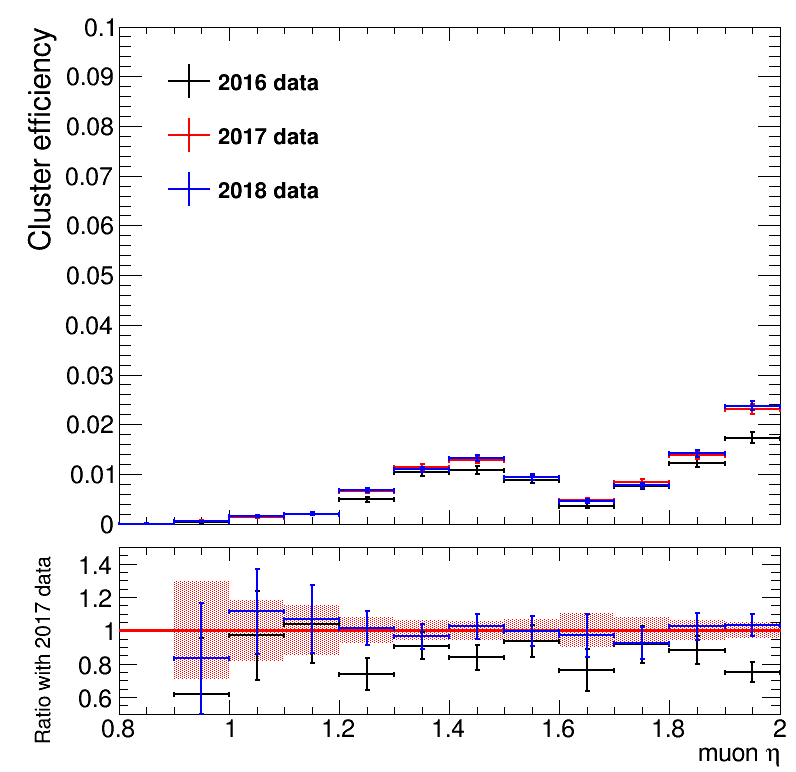

In [64]:
# cluster efficiency vs eta
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


h = {}
bins = [12, 0.8, 2]
for i, k in enumerate(['data16', 'data17', 'data18']):
    
    selections = clusterSize[k]>=130
    selections = np.logical_and(selections, clusterTimeSpread[k]<20)

    selections = np.logical_and(selections, np.logical_and(clusterTimeTotal[k]<12.5, clusterTimeTotal[k]>-5))

    selections = np.logical_and(selections, clusterMe11Ratio[k]<1.0)

    hm = create_TH1D( np.abs(clusterEta[k][selections]),  axis_title=['muon #eta', 'Cluster efficiency'],name=k, binning=bins)
    hb = create_TH1D( np.abs(lepEta[k]),  axis_title=['muon #eta', 'Cluster efficiency'],name=k, binning=bins)
    h[k] = rt.TEfficiency(hm,hb)
    h[k].SetLineColor(std_color_list[i])
    h[k].SetLineWidth(2)
    print(k, ' efficiency', h[k].GetEfficiency(1),h[k].GetEfficiencyErrorUp(1),h[k].GetEfficiencyErrorLow(1))
    

c = make_ratio_pEff([h['data16'],h['data17'],h['data18']], fit = False, logy=False, in_tags = ['2016 data', '2017 data', '2018 data'], \
                        ratio_bounds = [0.5,1.5], ratio_index = 1, draw_opt = ['E1','E2','E1']) 
c.Draw()